# EasyMLP: Some Simple Examples

## Imports

In [1]:
import sys
sys.path.append(".")
from easy_mlp.models import MLP
from easy_mlp.trainers import MLPTrainer
from easy_mlp.data import get_tensors, get_data_loaders
from easy_mlp.helpers import get_loss_fn, get_optimiser, param_init

import torch
import numpy as np
import pretty_plotly.plot as pp
from sklearn.datasets import load_iris, load_breast_cancer, fetch_california_housing, make_classification, make_regression
from sklearn.model_selection import train_test_split

## Set Device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

## Regression

### Data Loading and Preprocessing

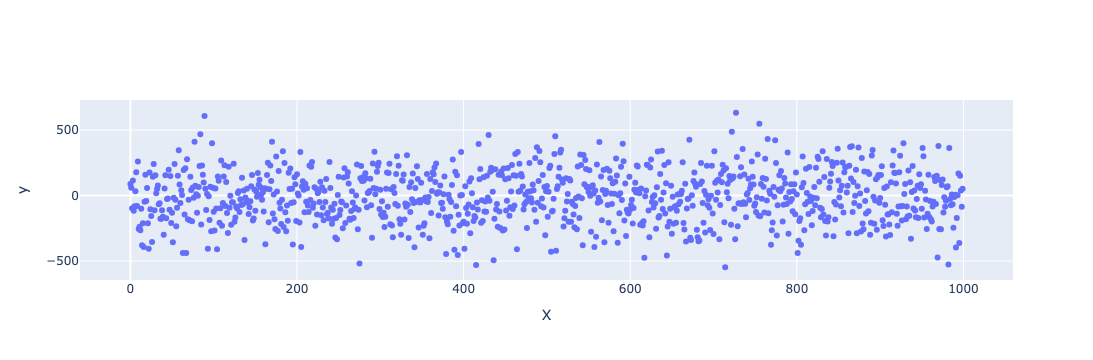

In [3]:
# # Get California Housing Data
# X, y = fetch_california_housing(return_X_y=True)
# x = np.arange(0, y.shape[0])
# pp.plot_data(x, y, x_label="X", y_label="y")

# Generate random data
X, y = make_regression(n_samples=1000, n_features=100)
x = np.arange(0, y.shape[0])
pp.plot_data(x, y, x_label="X", y_label="y")

In [4]:
# Dataloading parameters
batch_size = 8
test_size = 0.2
val_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (640, 100)
y_train: (640,)
X_val: (160, 100)
y_val: (160,)
X_test: (200, 100)
y_test: (200,)


In [5]:
# Get tensors and dataloaders
X_train, y_train, X_val, y_val = get_tensors(X_train, y_train, X_val, y_val)
train_loader, val_loader = get_data_loaders(X_train, y_train, X_val, y_val, batch_size)

### Building the Model

In [6]:
# Training parameters
num_train_epochs = 10
l_rate = 1e-03
loss_choice = "mse"
optim_choice = "adam"

# Create configuration for model layers
layer_config_1 = [ # a simple linear regression model (a perceptron with no activation)
    (X_train.shape[1], None, None),
    (1, None, None),
]

layer_config_2 = [ # a multi-layer perceptron
    (X_train.shape[1], None, None),
    (200, "relu", None),
    (300, "relu", None),
    (400, "relu", 0.1),
    (200, "relu", None),
    (1, None, None),
]

# Initialise model
reg_model = MLP(layer_config=layer_config_2, model_name="RegModel")
reg_model.set_model_layers()

# Initialise model parameters
reg_model.apply(lambda m: param_init(m, "xavier"))

# Move model to selected device
reg_model.to(device)

print(reg_model)
print(f"Number of trainable parameters: {sum(p.numel() for p in reg_model.parameters())}")

MLP(
  (model): ModuleList(
    (0): Linear(in_features=100, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=400, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.1, inplace=False)
    (7): Linear(in_features=400, out_features=200, bias=True)
    (8): ReLU()
    (9): Linear(in_features=200, out_features=1, bias=True)
  )
)
Number of trainable parameters: 281301


### Training the Model

#### Loss Function and Optimiser

In [7]:
loss_fn = get_loss_fn(loss_choice)  # Mean-square error loss because this a regression task
optimiser = get_optimiser(optim_choice, reg_model, l_rate) # adam

#### Training Loop

In [8]:
reg_trainer = MLPTrainer(type="reg", is_multiclass=False)

reg_trainer.train(
    reg_model,
    num_train_epochs,
    optimiser,
    loss_fn,
    train_loader,
    val_loader,
    device=device,
)

    |                       TRAINING SET                       ||                      VALIDATION SET                      |
    |   Loss   ||   RMSE   ||   MSE    ||   MAE    ||    R2    ||   Loss   ||   RMSE   ||   MSE    ||   MAE    ||    R2    |
001 | 2.15e+05 || 1.64e+02 || 2.69e+04 || 1.28e+02 || 2.72e-01 || 7.70e+03 || 8.77e+01 || 7.70e+03 || 6.98e+01 || 7.72e-01 |
002 | 2.77e+04 || 5.89e+01 || 3.46e+03 || 4.55e+01 || 9.06e-01 || 2.85e+03 || 5.34e+01 || 2.85e+03 || 4.31e+01 || 9.15e-01 |
003 | 8.17e+03 || 3.20e+01 || 1.02e+03 || 2.55e+01 || 9.72e-01 || 1.56e+03 || 3.95e+01 || 1.56e+03 || 3.20e+01 || 9.54e-01 |
004 | 5.45e+03 || 2.61e+01 || 6.81e+02 || 2.05e+01 || 9.82e-01 || 1.53e+03 || 3.91e+01 || 1.53e+03 || 3.06e+01 || 9.55e-01 |
005 | 3.24e+03 || 2.01e+01 || 4.06e+02 || 1.60e+01 || 9.89e-01 || 1.62e+03 || 4.03e+01 || 1.62e+03 || 3.21e+01 || 9.52e-01 |
006 | 2.69e+03 || 1.83e+01 || 3.36e+02 || 1.43e+01 || 9.91e-01 || 1.30e+03 || 3.61e+01 || 1.30e+03 || 2.87e+01 || 9.61e-01 |


#### Visualising Training Results

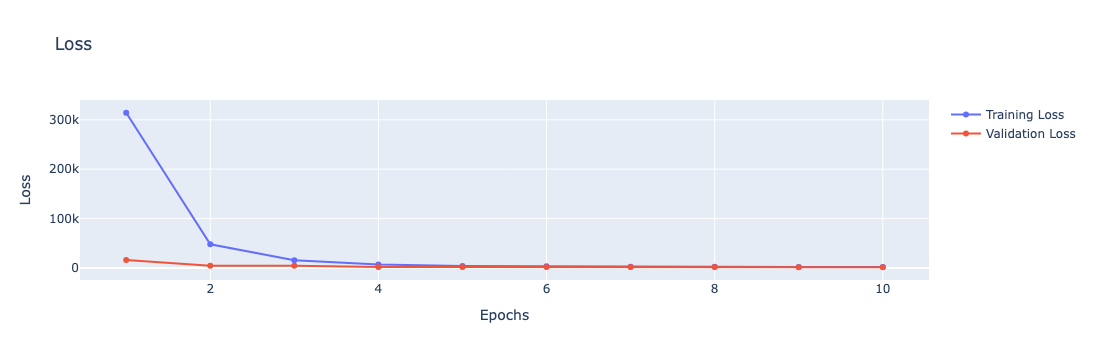

In [9]:
reg_trainer.mm.get_metric_chart("loss")

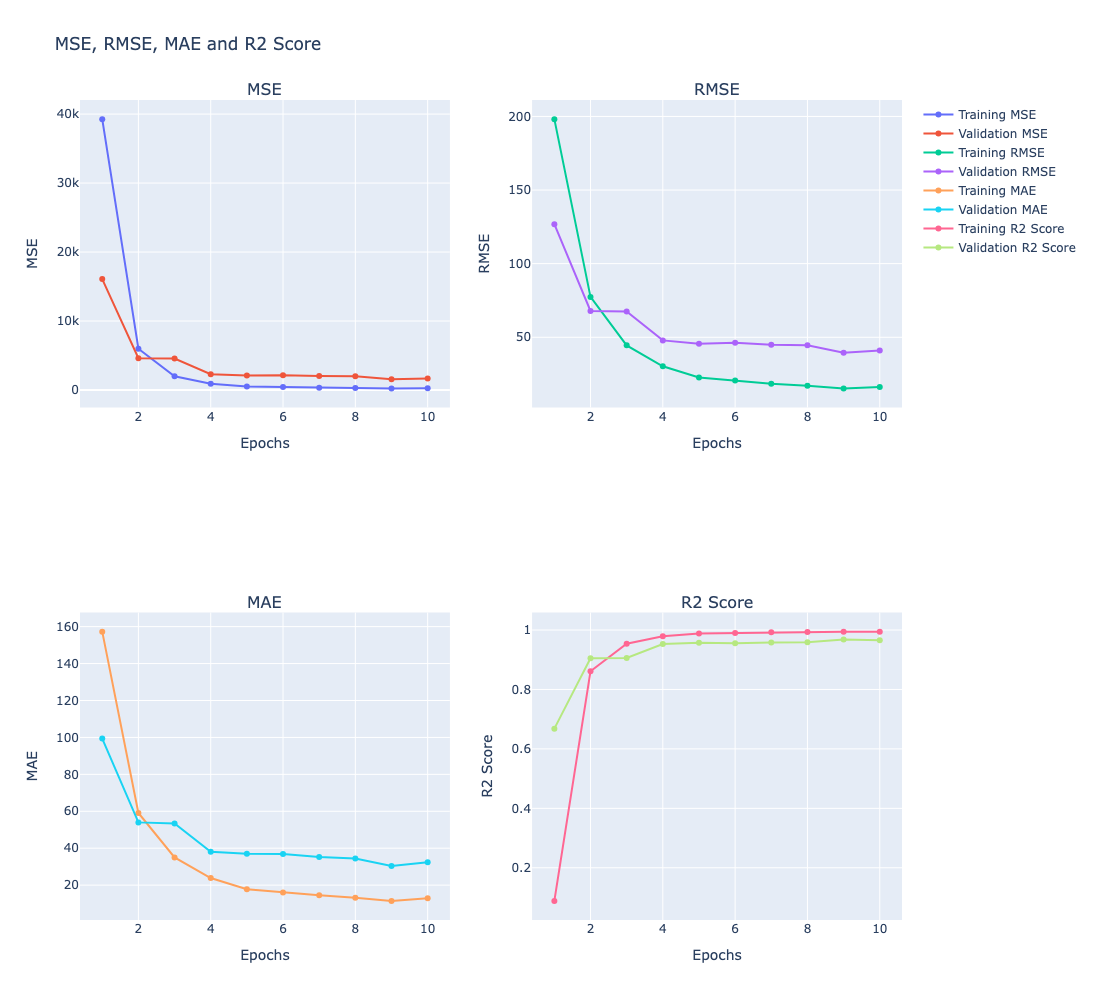

In [10]:
reg_trainer.mm.get_metric_chart_collection(["mse", "rmse", "mae", "r2"])

### Evaluating the Model on Test Data

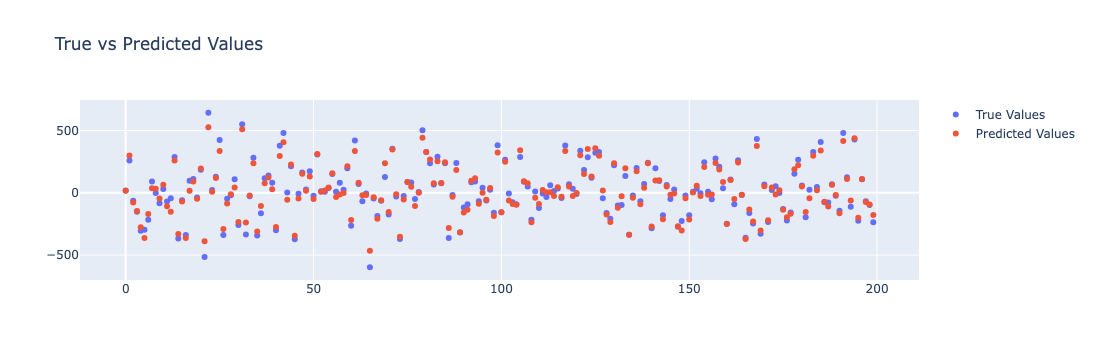

In [11]:
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

reg_model.eval()

with torch.no_grad():
    test_preds = reg_model(X_test)
    test_preds = test_preds.float().cpu().numpy().flatten()

x = np.arange(0, X_test.shape[0])
pp.plot_data(
    true_vals=pp.create_trace(x, y_test, name="True Values", mode="markers"),
    pred_vals=pp.create_trace(x, test_preds, name="Predicted Values", mode="markers"),
    title="True vs Predicted Values",
)

## Binary Classification

### Data Loading and Preprocessing

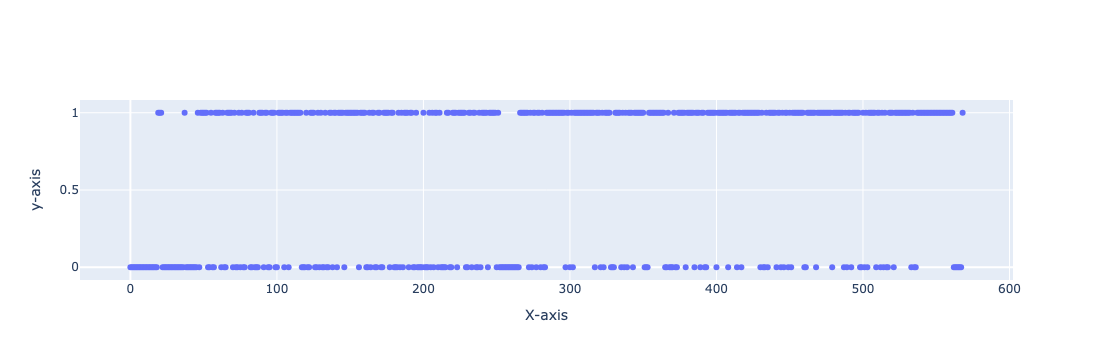

In [12]:
# Get breast cancer data
X, y = load_breast_cancer(return_X_y=True)
x = np.arange(0, y.shape[0])
pp.plot_data(x, y, x_label="X-axis", y_label="y-axis")

# # Generate random data
# X, y = make_classification(n_samples=1000, n_features=100, n_classes=2)
# x = np.arange(0, y.shape[0])
# pp.plot_data(x, y, x_label="X-axis", y_label="y-axis")

In [13]:
# Dataloading parameters
batch_size = 8
test_size = 0.2
val_size = 0.2

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, random_state=42)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (364, 30)
y_train: (364,)
X_val: (91, 30)
y_val: (91,)
X_test: (114, 30)
y_test: (114,)


In [14]:
# Get tensors and dataloaders
X_train, y_train, X_val, y_val = get_tensors(X_train, y_train, X_val, y_val)
train_loader, val_loader = get_data_loaders(X_train, y_train, X_val, y_val, batch_size)

### Building the Model

In [15]:
# Training parameters
num_train_epochs = 20
l_rate = 1e-02
pred_threshold = 0.5
loss_choice = "binary"
optim_choice = "adam"

# Create configuration for model layers
layer_config_1 = [ # a simple logistic regression model (a perceptron)
    (X_train.shape[1], None, None),
    (1, "sigmoid", None),
]

layer_config_2 = [ # a multi-layer perceptron
    (X_train.shape[1], None, None),
    (200, "relu", None),
    (300, "relu", None),
    (400, "relu", 0.1),
    (200, "relu", None),
    (1, "sigmoid", None),
]

# Initialise model
b_cls_model = MLP(layer_config=layer_config_1, model_name="BinClsModel")
b_cls_model.set_model_layers()

# Initialise model parameters
b_cls_model.apply(lambda m: param_init(m, "xavier"))

# Move model to selected device
b_cls_model.to(device)

print(b_cls_model)
print(f"Number of trainable parameters: {sum(p.numel() for p in b_cls_model.parameters())}")

MLP(
  (model): ModuleList(
    (0): Linear(in_features=30, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
Number of trainable parameters: 31


### Training the Model

#### Loss Function and Optimiser

In [16]:
loss_fn = get_loss_fn(loss_choice)  # Binary cross-entropy loss because this a binary classification task
optimiser = get_optimiser(optim_choice, reg_model, l_rate) # adam

#### Training Loop

In [17]:
b_cls_trainer = MLPTrainer(type="cls", is_multiclass=False)

b_cls_trainer.train(
    b_cls_model,
    num_train_epochs,
    optimiser,
    loss_fn,
    train_loader,
    val_loader,
    pred_threshold=pred_threshold,
    device=device,
)

    |                       TRAINING SET                       ||                      VALIDATION SET                      |
    |   Loss   || Accuracy || Precison ||  Recall  ||    F1    ||   Loss   || Accuracy || Precison ||  Recall  ||    F1    |
001 | 2.89e+02 || 6.35e-01 || 6.35e-01 || 1.00e+00 || 7.76e-01 || 3.75e+01 || 6.04e-01 || 6.04e-01 || 1.00e+00 || 7.53e-01 |
002 | 2.89e+02 || 6.35e-01 || 6.35e-01 || 1.00e+00 || 7.76e-01 || 3.75e+01 || 6.04e-01 || 6.04e-01 || 1.00e+00 || 7.53e-01 |
003 | 2.89e+02 || 6.35e-01 || 6.35e-01 || 1.00e+00 || 7.76e-01 || 3.75e+01 || 6.04e-01 || 6.04e-01 || 1.00e+00 || 7.53e-01 |
004 | 2.89e+02 || 6.35e-01 || 6.35e-01 || 1.00e+00 || 7.76e-01 || 3.75e+01 || 6.04e-01 || 6.04e-01 || 1.00e+00 || 7.53e-01 |
005 | 2.89e+02 || 6.35e-01 || 6.35e-01 || 1.00e+00 || 7.76e-01 || 3.75e+01 || 6.04e-01 || 6.04e-01 || 1.00e+00 || 7.53e-01 |
006 | 2.89e+02 || 6.35e-01 || 6.35e-01 || 1.00e+00 || 7.76e-01 || 3.75e+01 || 6.04e-01 || 6.04e-01 || 1.00e+00 || 7.53e-01 |


#### Visualising Training Results

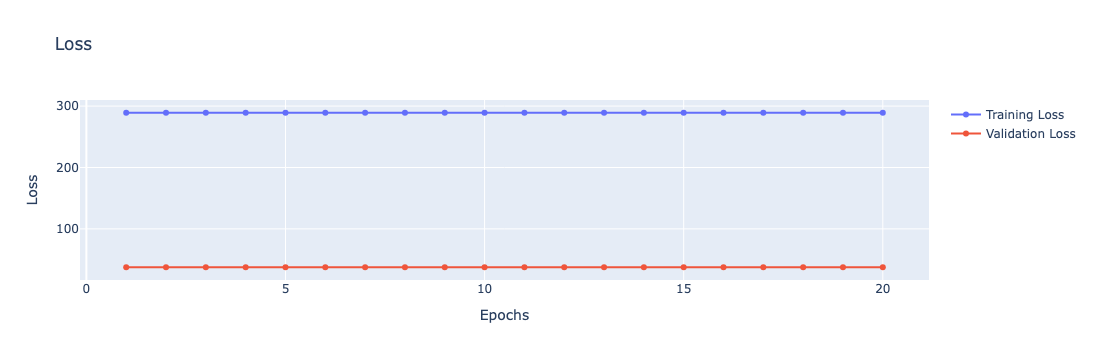

In [18]:
b_cls_trainer.mm.get_metric_chart("loss")

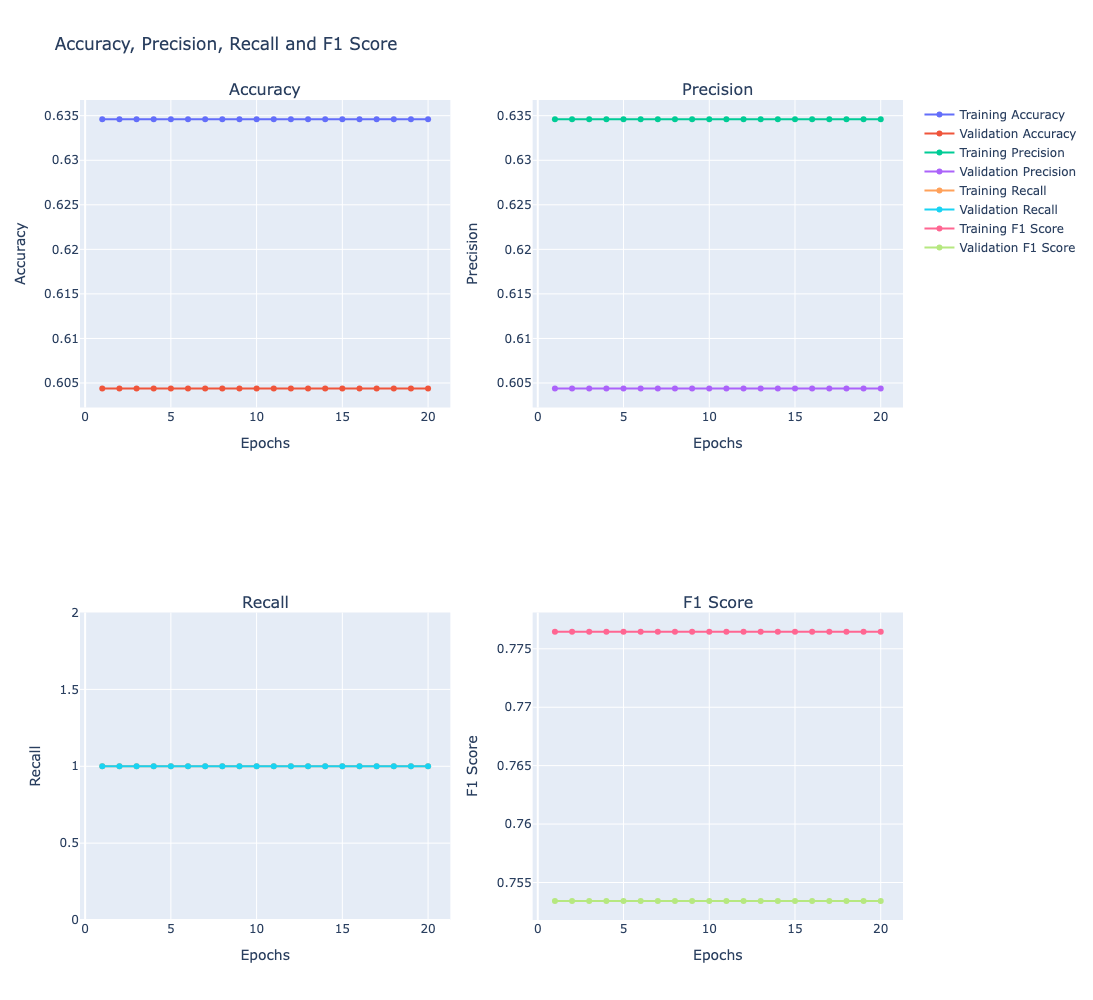

In [19]:
b_cls_trainer.mm.get_metric_chart_collection(["acc", "prec", "rec", "f1"])

### Evaluating the Model on Test Data

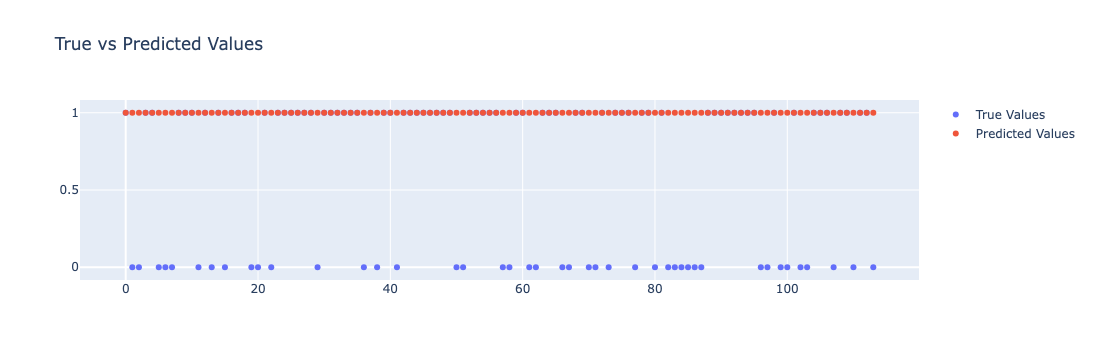

In [20]:
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)

b_cls_model.eval()

with torch.no_grad():
    test_preds = b_cls_model(X_test)
    test_preds = (test_preds.detach().clone() > pred_threshold)
    test_preds = test_preds.float().cpu().numpy().flatten()

x = np.arange(0, X_test.shape[0])
pp.plot_data(
    true_vals=pp.create_trace(x, y_test, name="True Values", mode="markers"),
    pred_vals=pp.create_trace(x, test_preds, name="Predicted Values", mode="markers"),
    title="True vs Predicted Values",
)

In [21]:
# Test accuracy
test_acc = ((test_preds == y_test).sum() / y_test.shape[0]) 
print(f"Final accuracy: {test_acc * 100:.2f}%")

Final accuracy: 62.28%


## Multiclass Classification